In [1]:
import tensorflow as tf
import numpy as np
import os
import random

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

import splitfolders

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.8.2


### Random seed for reproducibility

In [2]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## EfficientNet B0 Fine Tuning

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Metadata

In [4]:
LABELS = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species2',       # 4
          'Species2',       # 5
          'Species7',       # 6
          'Species8',       # 7
          ]

In [5]:
INPUT_SHAPE = (256, 256, 3)
IMAGE_SIZE = (INPUT_SHAPE[0], INPUT_SHAPE[1])
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_CLASSES = len(LABELS)
MODEL_NAME = "cnn"

## Data Loader

In [6]:
from PIL import Image
import os

path = "dataset"

dirs = os.listdir(path)

print(dirs)



['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']


In [7]:
# Splitting the main dataset into train and val
dataset_dir = 'datasetNoTest'

if not(os.path.exists('../datasetNoTest')) :
    print('splitting')
    splitfolders.ratio('dataset', output='datasetNoTest', seed=seed, ratio=(0.8, 0.2))

# Setting dataset directories
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

## Image Generators

In [8]:
training_dir = 'datasetNoTest/train'
# Constructor
train_data_gen = ImageDataGenerator(
    # Data Augmentation
    rotation_range=30,
    height_shift_range=50,
    width_shift_range=50,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='reflect',
    preprocessing_function=preprocess_input
)

# Generator
train_gen = train_data_gen.flow_from_directory(
    directory=training_dir,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed
)

Found 2829 images belonging to 8 classes.


In [9]:
validation_dir = 'datasetNoTest/val'
# Constructor
test_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generator
test_gen = test_data_gen.flow_from_directory(
    directory=validation_dir,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=seed
)

Found 713 images belonging to 8 classes.


## Model Design

### Utilities

In [10]:
# Utility function to create folders and callbacks for training
def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('models')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    exp_dir = os.path.join(exps_dir, model_name)
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'),
                                                       save_weights_only=False, # True to save only weights
                                                       save_best_only=False) # True to save only the best epoch
    callbacks.append(ckpt_callback)

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

## Fine Tuning Model

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0

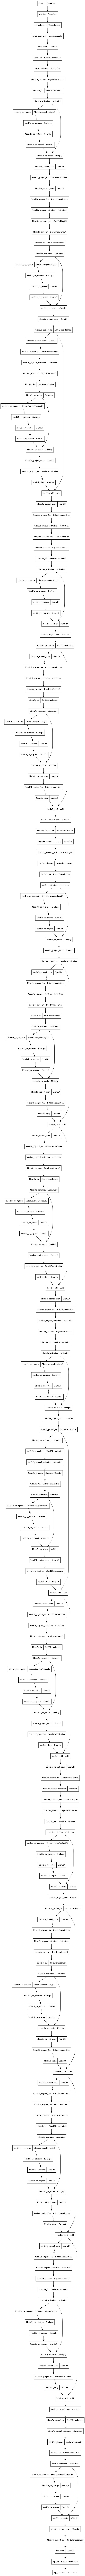

In [11]:
# Download and plot the EfficientNet B0 model
supernet = tfk.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE
)

# Plot the model
supernet.summary()
tfk.utils.plot_model(supernet)

### Model Classifier

In [13]:
supernet.trainable = False

# Rebuild the classifier
inputs = tfk.Input(shape=INPUT_SHAPE)
x = supernet(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(256, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.ReLU()(x)
outputs = tfkl.Dense(
    NUM_CLASSES,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256)               0     

### Freeze the first layers of EfficientNet

In [14]:
# Set all EfficientNet layers to True
model.get_layer('efficientnetb0').trainable = True
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 block

In [15]:
for i, layer in enumerate(model.get_layer('efficientnetb0').layers[:162]):
    layer.trainable=False

print()
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
    print(i, layer.name, layer.trainable)
model.summary()


0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape 

In [16]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256)               0     

## Training and Validation

In [17]:
# Save best epoch model
# Create folders and callbacks
callbacks = create_folders_and_callbacks(model_name=MODEL_NAME)

# Train the model
history = model.fit(
    x = train_gen,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = test_gen,
    callbacks=[callbacks]
).history

Epoch 1/100
 6/89 [=>............................] - ETA: 3:44 - loss: 2.2801 - accuracy: 0.1667

KeyboardInterrupt: 

In [ ]:
# Plot the training history
plt.figure(figsize=(10,5))
plt.plot(history['loss'], alpha=.3, color='r', linestyle='--', linewidth=3)
plt.plot(history['val_loss'], label='EfficientNet B0', alpha=.8, color='r', linewidth=3)
plt.legend(loc='upper right', prop={'size': 18})
plt.title('Categorical Crossentropy', fontsize=20)
plt.grid(alpha=.3)

plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], alpha=.3, color='r', linestyle='--', linewidth=3)
plt.plot(history['val_accuracy'], label='EfficientNet B0', alpha=.8, color='r', linewidth=3)
plt.legend(loc='upper right', prop={'size': 18})
plt.title('Accuracy', fontsize=20)
plt.grid(alpha=.3)

plt.show()

## Testing

In [ ]:
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)

# Evaluate on test
predictions = model.predict(test_gen, steps=test_steps_per_epoch)

In [ ]:
# Get most likely classes
predicted_classes = np.argmax(predictions, axis=-1)

In [ ]:
# Get true classes
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(class_labels), yticklabels=class_labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Save the Model

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/EfficientNetB0")